In [ ]:
import sqlite3 as lite
import pandas as pd

### Subqueries   

A Subquery or Inner query or a Nested query  
is a query within another SQL query and embedded within clauses,  
most commonly in the **WHERE** clause.  

Data returned by a subquery is used in the main query as a condition to further restrict the data to be retrieved.  

Subqueries can be used with the SELECT, INSERT, UPDATE, and DELETE statements  
along with the operators like =, <, >, >=, <=, IN, BETWEEN, etc.  

1. Subqueries are enclosed within parentheses.
2. ORDER BY command cannot be used in a subquery, although the main query can use an ORDER BY.  
3. Subqueries that return more than one row can only be used with multiple value operators such as the IN operator.  
4. The SELECT list cannot include any references to values that evaluate to a BLOB, CLOB(unicode character-based data), and ARRAY.  
    SQLite does not support ARRAY and CLOB data types.  

Results of subqueries can be used in main queries. 

##### Scalar value     
A scalar value has one component to it, the magnitude.  
A scalar-valued function (SVF) returns a single value, such as a string, integer, or bit value.  
[SQLite built-in scalar functions](https://www.sqlite.org/lang_corefunc.html)    
We can create also our own functions (stored procedures)   

In [31]:
normal_query = """
  SELECT Name, Age FROM Students
  WHERE Age<18;
"""

sub_query =  """
  SELECT Name, Age FROM Students
  WHERE Age IN 
    (SELECT Age FROM Students WHERE Age < 18);   -- subquery
"""

with lite.connect('../Databases/BTechData.sqlite') as con:    
    df1 = pd.read_sql(normal_query, con)
    df2 = pd.read_sql(sub_query, con)

print("Regular Query:")
print(df1)  
print("\nWith Sub Query:")
print(df2)  

Regular Query:
                Name  Age
0  ANEESH B KULKARNI   17
1         KEERTHI GM   17
2           PRACHI G   17
3      MONISH RAJ SR    0

With Sub Query:
                Name  Age
0  ANEESH B KULKARNI   17
1         KEERTHI GM   17
2           PRACHI G   17
3      MONISH RAJ SR    0


#### CREATE and INSERT values to a new table   
In this case, SELECT rows to insert into a new table is not a subquery  
because what is returned is neither a scalar value nor a collection to check membership.   

In [33]:
temp_query = """
CREATE TEMP TABLE non_voters AS
    SELECT * FROM Students
      WHERE Age<18;
"""

with lite.connect('../Databases/BTechData.sqlite') as con:
    con.execute(temp_query)
    con.commit()
    df_temp = pd.read_sql("SELECT * FROM non_voters", con)

df_temp    

,USN,Name,Email,Section,Sex,Date_of_Birth,Height_cm,Weight_Kg,Age
0,1RVU22CSE025,ANEESH B KULKARNI,aneeshk,B,M,2005-08-27,180,62,17
1,1RVU22CSE056,KEERTHI GM,keerthigm,B,F,2005-10-12,164,48,17
2,1RVU22CSE115,PRACHI G,prachig,B,F,2005-10-03,152,46,17
3,1RVU22CSE134,MONISH RAJ SR,monishrajsr,A,M,2023-04-24,180,80,0


#### Aside   
Visualise data for better understanding   

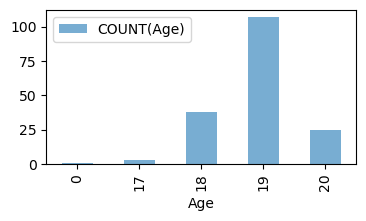

In [34]:
ordby = """
SELECT Age, COUNT(Age)
FROM Students
GROUP BY Age
"""

with lite.connect ('../Databases/BTechData.sqlite') as con:
    df = pd.read_sql(ordby, con)

df.set_index('Age').plot.bar(figsize=(4,2), alpha=0.6);

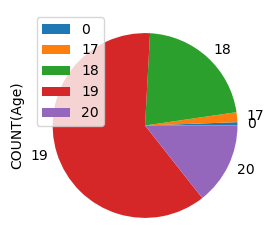

In [35]:
df.set_index('Age').plot.pie(y='COUNT(Age)', figsize=(3,3));

---
#### Eample: Find  suspected duplicate elector records       
Elector records with phonetically matching (name + relative name) are suspected to be duplicated.  
We have recorded `metaphones` for the voter records.   

Consider voter records of one part(booth) - AC 150, Part 93 with 1,322 voters.   
1. read voter data to a dataframe   

In [37]:
df = pd.read_excel('../Data/KA1500093.xlsx')
print(f"Electors in Part KA1500093 = {len(df)}")
print(df.columns); print()

df[['Part', 'Section', 'Serial', 'House', 'EPIC', 'Name', 'Relative', 'metaphone']].head()

Electors in Part KA1500093 = 1322
Index(['Part', 'Ward', 'Section', 'Serial', 'House', 'EPIC', 'Name', 'Sex',
       'Age', 'Relative', 'Reln', 'Status', 'metaphone', 'meta_name',
       'meta_rel'],
      dtype='object')



,Part,Section,Serial,House,EPIC,Name,Relative,metaphone
0,KA1500093,1,1,...,XTE3756681,SYED GOWS,MAHAMED SAB,STKSMHMTSP
1,KA1500093,1,2,...,XTE3756723,YASMIN,SYED GOWS,ASMNSTKS
2,KA1500093,1,3,"46, 9th Cross",XTE4055794,ASHWIN JOSHI JOSHY,LAXMINARAYANA JOSHY,AXNJXJXLKSMNRNJX
3,KA1500093,1,4,-,XTE3847969,MARAPPA,SRIRANGANNA,MRPSRRNKN
4,KA1500093,1,5,-,XTE3847894,PRIYAMMA,MARAPPA,PRMMRP


In [38]:
con = lite.connect(":memory:")
sql = """
   CREATE TABLE voters(
     Section Int, 
     Serial Int, 
     House Text, 
     Name Text, 
     Sex Text,
     Age Int, 
     Relative Text, 
     metaphone Text)
"""
con.execute(sql)
con.commit()

2. insert select columns into an in-memory database table  

In [39]:
df[['Section', 'Serial', 'House', 'Name', 'Sex',
    'Age', 'Relative', 'metaphone']].to_sql('voters', con, if_exists='append', index=False)

1322

3. create a tuple of metaphones with count > 1, the suspected duplicate entries,   
   . SQL IN operators takes a tuple as argument   
   . observe the HAVING clause within ORDER BY clause   

In [43]:
sql = """
    SELECT metaphone 
    FROM voters
    GROUP BY metaphone
        HAVING COUNT(metaphone) > 1
    ORDER BY
      COUNT(metaphone) DESC
"""
dupl = list(con.execute(sql))
dupl = tuple([d[0] for d in dupl])
print(f"{len(dupl)}\n {dupl}")

17
 ('STNRNJRMMHNRJ', 'SJ0NKRJP', 'SF0SKRPRSTKS', 'RMXKXTRT', 'PXPL0KMNJN0TP', 'PRSTRTSRSPRTSR', 'PLSMFF0LNKMK', 'PFNSTKTSM', 'NRNRTAX0RT', 'MLKAMRN0RTPR', 'LKXMMNRNSM', 'KRPRSTKSXFNMR', 'F0RNXN0PKXTNNTPP', 'ATNRSNKMSSRNTRSNKM', 'ANRTPPRJ0K', 'AMXSKP', 'AJKKN0RJN')


4. get the voter records with the above metaphones   

In [44]:
sql = f"""
    SELECT * 
    FROM voters
    WHERE metaphone IN {dupl}
    ORDER BY metaphone
"""
pd.read_sql(sql, con)

,Section,Serial,House,Name,Sex,Age,Relative,metaphone
0,1,437,17,AJAY A K,M,23,KANTHARAJU A N,AJKKN0RJN
1,1,439,17,AJAY A K,M,24,KANTHARAJU A N,AJKKN0RJN
2,1,779,39,UMESH,M,26,SOOGAPPA,AMXSKP
3,1,780,39,UMESHA,M,26,SUGAPPA,AMXSKP
4,1,402,2022-03-15 00:00:00,ANURADHA B,F,29,PRAGITH C H,ANRTPPRJ0K
5,1,403,2016-03-15 00:00:00,ANURADHA B,F,30,PRAJEETH C H,ANRTPPRJ0K
6,1,225,9,UDAYNAR SINGH M S,M,32,SURENDAR SINGH M,ATNRSNKMSSRNTRSNKM
7,1,339,13,UDAY NAR SINGH M S,M,33,SURENDAR SINGH M,ATNRSNKMSSRNTRSNKM
8,1,1084,#127,FATHER NISHANTH B C,M,21,CHIDANANDA B B,F0RNXN0PKXTNNTPP
9,1,#1084,127,FATHER NISHANTH B C,M,20,CHIDANANDA B B,F0RNXN0PKXTNNTPP


#### Operations 3 and 4 above can be combined using a subquery   
The operation will be faster.  

In [ ]:
sql = """
    SELECT * 
    FROM voters
    WHERE metaphone IN                -- IN operator  
    -- begin subquery
    (SELECT metaphone                 -- list of repeated metaphones
    FROM voters
    GROUP BY metaphone
        HAVING COUNT(metaphone) > 1)
    -- end subquery   
    ORDER BY metaphone DESC        
"""
pd.read_sql(sql, con)

#### Subqueries with the INSERT Statement   
INSERT data returned from a subquery into another table.  
The selected data in the subquery can be modified with any of the character, date or number functions.
```
INSERT INTO table_name [ (column1 [, column2 ]) ]
   SELECT [ *|column1 [, column2 ]
   FROM table1 [, table2 ]
   [ WHERE VALUE OPERATOR ]
```

In [ ]:
sql = """
   CREATE TABLE dupl_records(
        Section Int, 
        Serial Int, 
        House Text, 
        Name Text, 
        Sex Text,
        Age Int, 
        Relative Text, 
        metaphone Text)
"""
con.execute(sql)
con.commit()

In [ ]:
sql = """
    INSERT INTO dupl_records  
    SELECT * FROM voters
    WHERE metaphone IN                  -- match metaphone  
    (SELECT metaphone 
    FROM voters
    GROUP BY metaphone
        HAVING COUNT(metaphone) > 1)    -- with duplicated metaphone
"""
con.execute(sql)
con.commit()

In [ ]:
pd.read_sql("SELECT * FROM dupl_records ORDER BY metaphone", con)

#### Subqueries with the UPDATE Statement   
The subquery can be used in conjunction with the UPDATE statement.  
Either single or multiple columns in a table can be updated when using a subquery with the UPDATE statement.
```
UPDATE table
SET column_name = new_value
[ WHERE OPERATOR [ VALUE ]
   (SELECT COLUMN_NAME
   FROM TABLE_NAME)
   [ WHERE) ]
```  
E.g., reduce the age of female voters older than 30 by one year.  
Another election promise of All Inida BTParty.     

In [ ]:
pd.read_sql("SELECT * FROM dupl_records WHERE Age >= 30 AND Sex = 'F'", con)

In [ ]:
sql = """
    UPDATE dupl_records
    SET Age = Age-2 
    WHERE Age IN 
    (SELECT Age FROM dupl_records
     WHERE Age >= 30
     AND Sex = 'F')
"""
con.execute(sql)
con.commit()


In [ ]:
pd.read_sql("SELECT * FROM dupl_records WHERE Age >= 30 AND Sex = 'F'", con)

#### Subqueries with the DELETE Statement   
```
DELETE FROM TABLE_NAME
[ WHERE OPERATOR [ VALUE ]
   (SELECT COLUMN_NAME
   FROM TABLE_NAME)
   [ WHERE) ]
```

In [ ]:
print(f'Super seniors {con.execute("SELECT COUNT(*) FROM voters WHERE Age > 80").fetchone()[0]:5}')
print(f'Total voters: {con.execute("SELECT COUNT(*) FROM voters").fetchone()[0]:5,}')

In [ ]:
sql = """
DELETE FROM voters
   WHERE AGE IN 
   (SELECT Age FROM voters
      WHERE Age > 80);
"""
con.execute(sql)
con.commit()

In [ ]:
print(f'Super seniors {con.execute("SELECT COUNT(*) FROM voters WHERE Age > 80").fetchone()[0]:5}')
print(f'Total voters: {con.execute("SELECT COUNT(*) FROM voters").fetchone()[0]:5,}')

In [ ]:
con.close()

---

In [ ]:
con = lite.connect('../Databases/BTech22.sqlite')

In [ ]:
pd.read_sql("SELECT * FROM sqlite_master", con)

In [ ]:
pd.read_sql("PRAGMA table_info(Students)", con)

In [ ]:
sql = """
  SELECT DISTINCT Elective
  From Students
"""
pd.read_sql(sql, con)

#### Create a look-up table for Electives    
Primary key auto-incremented integer.     
Insert fields other than PK value.  
PK will increment automatically.  

In [ ]:
con.execute("DROP TABLE IF EXISTS Electives");

In [ ]:
sql = """
   CREATE TEMP TABLE IF NOT EXISTS Electives(
      Elective_Id Integer PRIMARY KEY AUTOINCREMENT, 
      Elective_Name Text
);"""
con.execute(sql)
con.commit();

In [ ]:
sql = """
  INSERT INTO Electives(Elective_Name)      -- only name is input. Not PK value. 
  SELECT DISTINCT Elective FROM Students    -- unique elective names.  
"""
con.execute(sql)
con.commit();

In [ ]:
pd.read_sql("SELECT * FROM Electives", con)

##### temporary table is not persisted   

In [ ]:
with lite.connect('../Databases/BTech22.sqlite') as con:
    df = pd.read_sql("SELECT * FROM sqlite_master", con)

df    

In [ ]:
con.close()

#### Task   
Create master tables for Home_State, Home_Town, and Mother_Tongue using their standard code/acronym as primary key.   
Create master tables for Electives and Clubs using autoincremented Integers as PK.   

Deeply nested sub-queries will be harder to read and understand.  

#### Common Table Expression - CTE   
CTE and temp tables make the code easier to read, more modular.  
They reduce duplicated SQL code (which reduces bugs),  
and can even increase performance.